In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, when, count as spark_count, concat_ws, length, rand, row_number
from pyspark.sql.window import Window
import pandas as pd

from pyspark.ml.feature import StringIndexer, RegexTokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

def measure_time(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    return result, end - start

measure_time

<function __main__.measure_time(func, *args, **kwargs)>

In [2]:
spark = SparkSession.builder \
    .appName("RAID-TRAIN") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

spark

In [3]:
df = spark.read.json("hdfs://namenode:8020/user/raid/filtered_minilm")
df

DataFrame[attack: string, domain: string, features: array<double>, generation: string, id: string, model: string]

In [7]:
from pyspark.ml.functions import array_to_vector
df = df.withColumn("features", array_to_vector(col("features")))
df = df.repartition(128)
df

DataFrame[attack: string, domain: string, features: vector, generation: string, id: string, model: string]

In [8]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df)
pca_result = pca_model.transform(df)

In [9]:
pca_result

DataFrame[attack: string, domain: string, features: vector, generation: string, id: string, model: string, pca_features: vector]

In [10]:
print("Mengonversi ke Pandas...")
pca_pd, _ = measure_time(lambda: pca_result.select("model", "pca_features").toPandas())

Mengonversi ke Pandas...


In [11]:
# Ekstrak komponen PCA
pca_pd["pca_x"] = pca_pd["pca_features"].apply(lambda v: float(v[0]))
pca_pd["pca_y"] = pca_pd["pca_features"].apply(lambda v: float(v[1]))

# Opsional: tampilkan explained variance
explained_var = pca_model.explainedVariance.toArray()
print(f"Explained Variance (PC1, PC2): {explained_var[0]:.3f}, {explained_var[1]:.3f}")

Explained Variance (PC1, PC2): 0.066, 0.043


In [14]:
pca_pd

,model,pca_features,pca_x,pca_y
0,chatgpt,"[-0.027559367938136032, 0.011371187739920642]",-0.027559,0.011371
1,llama-chat,"[0.39834721022247455, 0.3869244821028211]",0.398347,0.386924
2,mistral,"[-0.37477491796661794, 0.2580914443621233]",-0.374775,0.258091
3,mistral,"[-0.4280089758518709, 0.4505562186970903]",-0.428009,0.450556
4,cohere,"[0.06111723688338408, 0.1091922322290025]",0.061117,0.109192
...,...,...,...,...
1869537,mistral,"[0.2579804579766404, 0.18503955863206]",0.257980,0.185040
1869538,gpt4,"[0.1146254484555177, -0.18672910604395274]",0.114625,-0.186729
1869539,gpt3,"[-0.11898918852119665, -0.07485466492604924]",-0.118989,-0.074855
1869540,mistral-chat,"[-0.4564530291400485, 0.40160308705342396]",-0.456453,0.401603


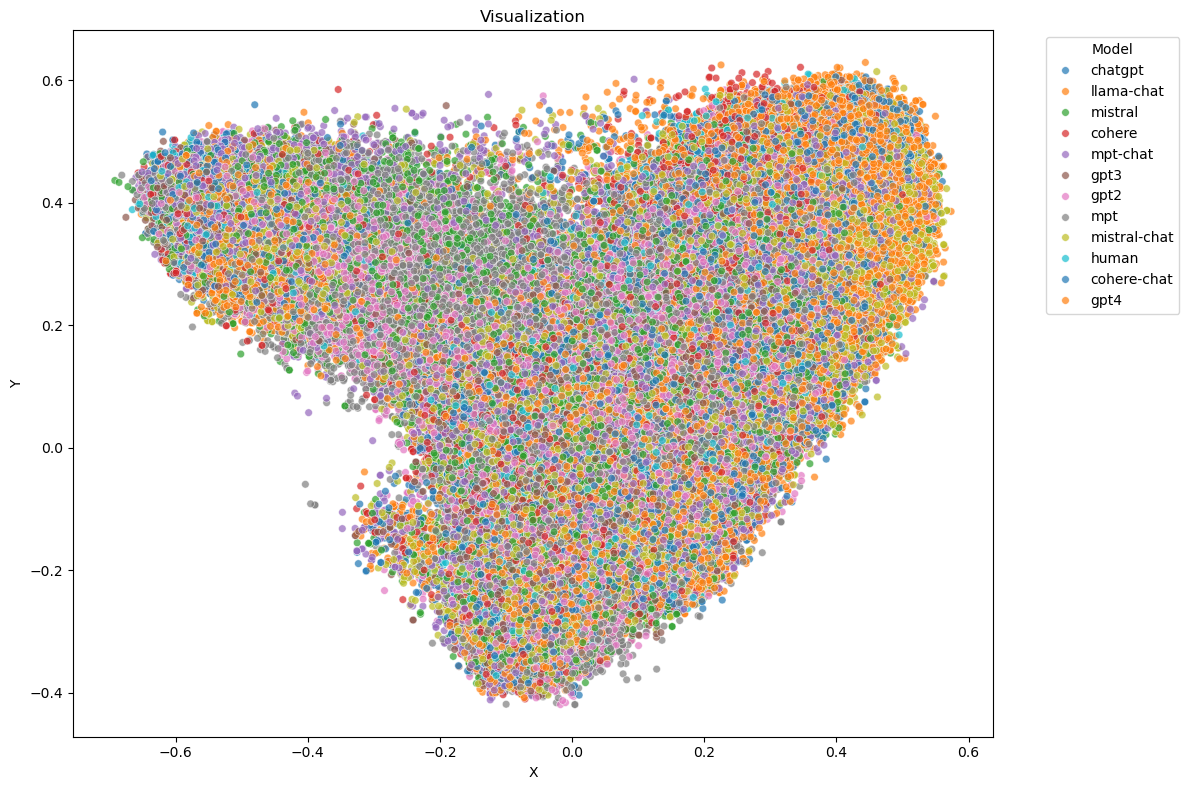

In [17]:
# 5. Visualisasi dengan Seaborn/Matplotlib
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pca_pd,
    x="pca_x",
    y="pca_y",
    hue="model",
    palette="tab10",
    alpha=0.7,
    s=30
)
plt.title("Visualization")
plt.xlabel(f"X")
plt.ylabel(f"Y")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("pca_minilm_2d.png", dpi=150)
plt.show()

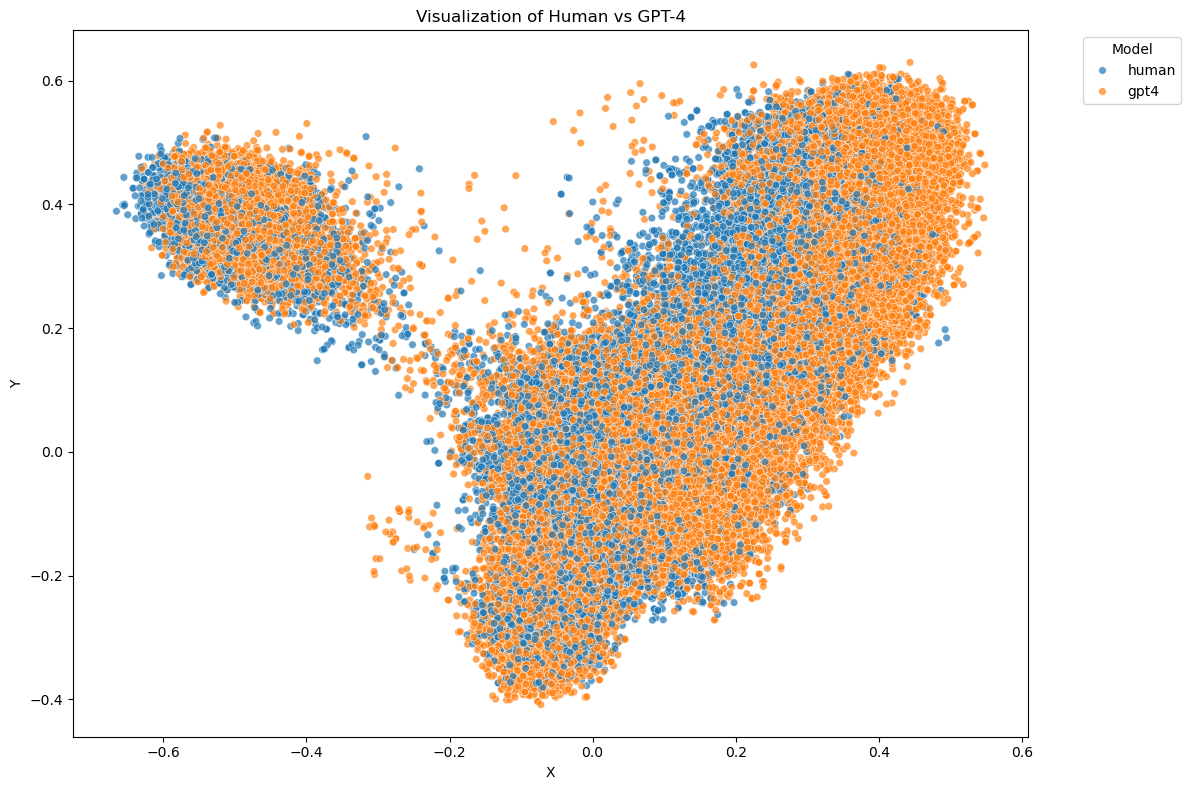

In [16]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pca_pd[pca_pd["model"].isin(["human", "gpt4"])],
    x="pca_x",
    y="pca_y",
    hue="model",
    palette=["#1f77b4", "#ff7f0e"],  # biru untuk human, oranye untuk gpt4 (opsional)
    alpha=0.7,
    s=30
)
plt.title("Visualization of Human vs GPT-4")
plt.xlabel(f"X")
plt.ylabel(f"Y")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("pca_minilm_human_gpt4_2d.png", dpi=150)
plt.show()